# Convert data to NILMTK format and load into NILMTK
# Convierta los datos al formato NILMTK y cárguelos en NILMTK

In [1]:
import nilmtk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

NILMTK utiliza un formato de archivo abierto basado en el formato de archivo binario HDF5 para almacenar tanto los datos de energía como los metadatos. El primer paso al utilizar NILMTK es convertir su conjunto de datos al formato de archivo NILMTK HDF5.

** NOTA**: Si está en Windows, recuerde escapar de las barras invertidas, use barras inclinadas hacia adelante o use cadenas sin procesar cuando pase rutas en Python, p. Ej. uno de los siguientes funcionaría:

```python
convert_redd('c:\\data\\REDD\\low_freq', r'c:\\data\\redd.h5')
convert_redd('c:/data/REDD/low_freq', 'c:/data/redd.h5')
convert_redd(r'c:\data\REDD\low_freq', r'c:\data\redd.h5')
```

## REDD

Convertir el conjunto de datos REDD como una estructura de datos .h5 es fácil:

**Nota** Solo ejecutar en caso que el archivo de datos redd.h5 este roto o no lo encuentre en sus archivos

In [2]:
from nilmtk.dataset_converters import convert_redd
#Guardar en formato h5
#convert_redd('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\low_freq', 'C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
#Guardar en formato en csv
#convert_redd('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\low_freq', 'C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd_LF.csv', 'CSV')

Ahora `redd.h5` contiene todos los datos de energía de REDD y todos los metadatos relevantes. En NILMTK v0.2, esta conversión solo usa una pequeña fracción de la memoria del sistema (a diferencia de NILMTK v0.1 que consumiría ~ 1 GByte de RAM solo para hacer la conversión del conjunto de datos).

Por supuesto, si desea ejecutar `convert_redd` en su propia máquina, primero debe descargar [REDD] (http://redd.csail.mit.edu), descomprimirlo y pasar los correspondientes` source_directory` y ʻoutput_filename `a` convert_redd () `.

## Otros DataSet


En el momento de escribir este artículo, [NILMTK contiene convertidores para 8 conjuntos de datos] (https://github.com/nilmtk/nilmtk/tree/master/nilmtk/dataset_converters).

¡Contribuir con un nuevo convertidor es fácil y muy recomendable! [Aprenda a escribir un convertidor de conjuntos de datos] (https://github.com/nilmtk/nilmtk/blob/master/docs/manual/development_guide/writing_a_dataset_converter.md).

## Abrir HDF5 en NILMTK

In [3]:
from nilmtk import DataSet
from nilmtk.utils import print_dict
directorio = ('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
redd = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5') #Puede cargarlo como csv

En este punto, todos los metadatos se han cargado en la memoria, pero no se ha cargado ninguno de los datos de energía. Este es nuestro primer encuentro con una diferencia fundamental entre NILMTK v0.1 y v0.2 +: NILMTK v0.1 solía cargar con entusiasmo todo el conjunto de datos en la memoria antes de que usted hiciera ningún trabajo real en los datos. ¡NILMTK v0.2 + es perezoso! No cargará datos en la memoria hasta que le diga lo que quiere hacer con los datos (e, incluso entonces, se cargarán grandes conjuntos de datos en trozos que quepan en la memoria). Esto permite que NILMTK v0.2 + funcione con conjuntos de datos arbitrariamente grandes (conjuntos de datos demasiado grandes para caber en la memoria) sin ahogar su sistema.

### Explorando el objeto `DataSet`

Echemos un vistazo rápido para ver qué hay en este objeto `redd` ...

Hay muchos metadatos asociados con el conjunto de datos, incluida información sobre los dos modelos de dispositivo de medición que los autores utilizaron para registrar REDD:

In [4]:
print_dict(redd.metadata)

También tenemos todos los edificios disponibles como [OrderedDict](https://docs.python.org/2/library/collections.html#collections.OrderedDict) (indexados desde 1 y no 0 porque cada conjunto de datos que conocemos comienza a numerar los edificios desde 1 y no con un 0)

In [5]:
#print_dict imprime los valores de anidados en un diccionario
print_dict(redd.buildings)

Cada edificio tiene un poco de metadatos asociados (no hay muchos metadatos específicos del edificio en REDD):

In [4]:
print_dict(redd.buildings[1].metadata)

Cada edificio tiene un atributo ʻelec` que es un objeto `MeterGroup` (¡mucho más sobre estos pronto!)

In [5]:
redd.buildings[1].elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

¡Sí, ahí es donde está toda la carne!

# Carga de datos en la memoria

La carga de API es fundamental para muchas operaciones nilmtk y proporciona una gran flexibilidad. Veamos las formas en las que podemos cargar datos de un NILMTK DataStore en la memoria. Para ver la gama completa de consultas posibles, usaremos el [conjunto de datos iAWE] (http://iawe.github.io) (cuyo archivo HDF5 se puede descargar [aquí] (https://copy.com/C2sIt1UfDx1mfPlC )).

La función `load` devuelve un *generador* de DataFrames cargados desde DataStore según las condiciones especificadas. Si no se especifican condiciones, se cargan todos los datos de todas las columnas. (Si no ha encontrado generadores de Python, podría valer la pena leer [esta guía rápida de generadores de Python] (http://stackoverflow.com/a/1756156/732596).)

**NOTA**: Si está en Windows, recuerde evitar de las barras invertidas, use barras inclinadas hacia adelante o use cadenas sin procesar cuando pase rutas en Python, p. Ej. uno de los siguientes funcionaría:

```python
iawe = DataSet('c:\\data\\iawe.h5')
iawe = DataSet('c:/data/iawe.h5')
iawe = DataSet(r'c:\data\iawe.h5')
```

#Lineas de código original, en nuestro caso ya cargamos los datos de REDD
from nilmtk import DataSet

iawe = DataSet('/data/iawe.h5') 

elec = iawe.buildings[1].elec 

elec

In [6]:
type(redd.buildings[1].elec)

nilmtk.metergroup.MeterGroup

Podemos seleccionar los electrodomesticos de un edificio con la función .building el cual es una colección de datos divididos, para seleccionar un edificio en particular escribirmos entre corchetes nuestro edificio objetivo. 

Las colecciones estan conformadas por objetos nilmtk.metergroup.MeterGroup que en este caso agrupan dispositivos por edificio, para seleccionar una colección de electrodomesticos basta con invocar el metodo .elec

In [7]:
#elec = redd.buildings[2].elec 
elec = redd.buildings[1].elec 
elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

**.elec** nos da información de los metadatos y algunas estadisticas basicas a partir de las medidas como: correlación entre medidas, suma de señales, instantes de tiempo donde el medidor funciono de manera correcta

Para seleccionar un dispositivo en particular lo hacemos invocando el dispositivo por medio de su etiqueta.

Veamos que medidas tenemos para la nevera:

In [8]:
fridge = elec['fridge']
fridge.available_columns()

[('power', 'active')]

Despues de seleccionar un dispositivo podemos acceder a las activaciones aisladas para dicho dispositivo por medio del método: .activation_series ()

### Firma: elec.activation_series (* args, ** kwargs)
Docstring:
Devuelve ejecuciones de un dispositivo.

La mayoría de los electrodomésticos pasan gran parte de su tiempo apagados. Esta función busca períodos en los que el aparato está encendido.

#### Parámetros
----------
**min_off_duration: int**
    Si min_off_duration> 0, ignore los períodos de 'apagado' inferiores a min_off_duration segundos de consumo de energía por debajo del umbral
    (Por ejemplo, es posible que una lavadora no consuma energía durante un período breve mientras la ropa se remoja). Valor predeterminado de los metadatos o, si no hay metadatos, el valor predeterminado es 0.
    
**min_on_duration: int**
    Se ignorará cualquier activación que dure menos de segundos que min_on_duration. Valor predeterminado de los metadatos o, si no hay metadatos, el valor predeterminado es 0.
    
**borde: int**
    Número de filas para incluir antes y después de la activación detectada on_power_threshold: int o float
    Por defecto es self.on_power_threshold ()
    
**kwargs : kwargs for self.power_series()**

#### Devoluciones
-------
lista de pd.Series. Cada serie contiene una activación.

.. nota :: Obsoleto

  Se eliminará la `serie_activación` en NILMTK v0.3.
  
  En su lugar, utilice `get_activations`.
  
Archivo: c: \ users \ josel \ anaconda3 \ envs \ nilmtk-env \ lib \ site-packages \ nilmtk \ electric.py

Tipo: método

In [9]:
señales_refrigerador = fridge.activation_series()

In [10]:
id_senial = 0
inicio = pd.to_datetime(señales_refrigerador[id_senial].index[0])
fin = pd.to_datetime(señales_refrigerador[id_senial].index[len(señales_refrigerador[0])-1])

print(f'{señales_refrigerador[id_senial].index[0]}')
print(f'{señales_refrigerador[id_senial].index[len(señales_refrigerador[0])-1]}')
print(f'Número de señales: {len(señales_refrigerador)}')
print(f'tipo inicio {type(inicio)}')
print(f'tipo fin {type(fin)}')

2011-04-18 10:17:36-04:00
2011-04-18 10:42:57-04:00
Número de señales: 727
tipo inicio <class 'pandas._libs.tslibs.timestamps.Timestamp'>
tipo fin <class 'pandas._libs.tslibs.timestamps.Timestamp'>


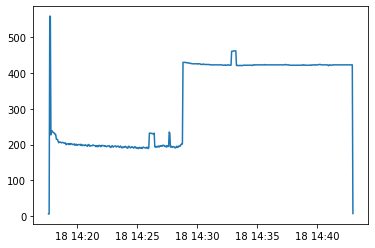

In [15]:
id_senial = 0
plt.plot(señales_refrigerador[id_senial])

Verificando si las señales coinciden entre las tomadas en el medidor del dispositivo y las que se aislaron mediante la libreria. 

In [46]:
c2_refrigerador = pd.read_csv('C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building2//elec//meter9.csv', 
                              header=[0,1])#, index_col=0)
c2_refrigerador = c5_refrigerador.iloc[0:,:].values
c2_refrigerador = pd.DataFrame(c5_refrigerador)
c2_refrigerador.rename(columns={0:'time', 1:'power'}, inplace=True)
#Cambiar a datos en formato de tiempo
c2_refrigerador['time'] = pd.to_datetime(c2_refrigerador['time'])
c2_refrigerador.set_index('time', inplace= True)
c2_refrigerador

,power
time,
2011-04-18 01:31:40-04:00,6
2011-04-18 01:31:44-04:00,6
2011-04-18 01:31:47-04:00,6
2011-04-18 01:31:50-04:00,7
2011-04-18 01:32:05-04:00,7
...,...
2011-05-22 19:58:54-04:00,159
2011-05-22 19:58:57-04:00,158
2011-05-22 19:59:01-04:00,158


In [79]:
#Tomar solo los datos para poder graficar
datos = c2_refrigerador.loc[inicio:fin, 'power'].values
print(f'Numero de datos en la señal {len(c2_refrigerador.loc[inicio:fin])}')

In [91]:
#Corroborar las datos en la sección cortada
c2_refrigerador.loc[inicio:fin]

,power
time,
2011-04-19 13:41:06-04:00,6
2011-04-19 13:41:14-04:00,180
2011-04-19 13:41:18-04:00,182
2011-04-19 13:41:21-04:00,183
2011-04-19 13:41:25-04:00,186
...,...
2011-04-19 14:00:53-04:00,155
2011-04-19 14:00:56-04:00,155
2011-04-19 14:01:00-04:00,157


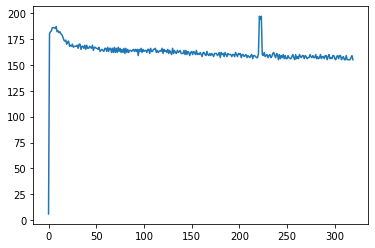

In [92]:
#Graficar los datos
plt.plot(datos)

Carguemos las señales del medidor central para ver que tipo de señal es la que se encuentra en el instante de tiempo en la que el refrigerador se enciende

In [97]:
c2_medidor1 = pd.read_csv('C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building2//elec//meter1.csv', 
                              header=[0,1])#, index_col=0)
c2_medidor1 = c2_medidor1.iloc[0:,:].values
c2_medidor1 = pd.DataFrame(c2_medidor1)
c2_medidor1.rename(columns={0:'time', 1:'power'}, inplace=True)


c2_medidor2 = pd.read_csv('C://Users//josel//SmartMeter//OrdenandoTodo//redd_LF//building2//elec//meter2.csv', 
                              header=[0,1])#, index_col=0)
c2_medidor2 = c2_medidor2.iloc[0:,:].values
c2_medidor2 = pd.DataFrame(c2_medidor2)
c2_medidor2.rename(columns={0:'time', 1:'power'}, inplace=True)

In [98]:
#Cambiar a datos en formato de tiempo
c2_medidor1['time'] = pd.to_datetime(c2_medidor1['time'])
#Dejar el tiempo como indice de los datos
c2_medidor1.set_index('time', inplace= True)
c2_medidor1

#Cambiar a datos en formato de tiempo
c2_medidor2['time'] = pd.to_datetime(c2_medidor2['time'])
#Dejar el tiempo como indice de los datos
c2_medidor2.set_index('time', inplace= True)
c2_medidor2

,power
time,
2011-04-17 19:18:27-04:00,290.24
2011-04-17 19:18:28-04:00,289.77
2011-04-17 19:18:29-04:00,289.76
2011-04-17 19:18:30-04:00,289.15
2011-04-17 19:18:31-04:00,304.64
...,...
2011-05-22 19:59:12-04:00,251.34
2011-05-22 19:59:13-04:00,251.72
2011-05-22 19:59:14-04:00,252.11


In [99]:
#Tomar solo los datos para poder graficar
datos2 = c2_medidor1.loc[inicio:fin, 'power'].values
print(f'Numero de datos en la señal {len(c2_medidor1.loc[inicio:fin])}')

#Tomar solo los datos para poder graficar
datos3 = c2_medidor2.loc[inicio:fin, 'power'].values
print(f'Numero de datos en la señal {len(c2_medidor2.loc[inicio:fin])}')

Numero de datos en la señal 1207
Numero de datos en la señal 1207


In [100]:
c2_medidor1.loc[inicio:fin]

,power
time,
2011-04-19 13:41:06-04:00,805.87
2011-04-19 13:41:07-04:00,814.33
2011-04-19 13:41:08-04:00,806.5
2011-04-19 13:41:09-04:00,808.44
2011-04-19 13:41:10-04:00,808.34
...,...
2011-04-19 14:01:08-04:00,14.6
2011-04-19 14:01:09-04:00,14.58
2011-04-19 14:01:10-04:00,14.6


In [101]:
c2_medidor2.loc[inicio:fin]

,power
time,
2011-04-19 13:41:06-04:00,23.97
2011-04-19 13:41:07-04:00,1222.78
2011-04-19 13:41:08-04:00,271.52
2011-04-19 13:41:09-04:00,268.13
2011-04-19 13:41:10-04:00,270.36
...,...
2011-04-19 14:01:08-04:00,251.78
2011-04-19 14:01:09-04:00,252.58
2011-04-19 14:01:10-04:00,252.61


inicio 2011-04-19 13:41:06-04:00 fin 2011-04-19 14:01:12-04:00


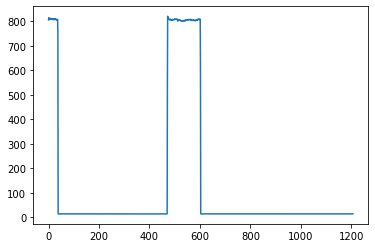

In [102]:
print(f'inicio {inicio} fin {fin}')
plt.plot(datos2)

inicio 2011-04-19 13:41:06-04:00 fin 2011-04-19 14:01:12-04:00


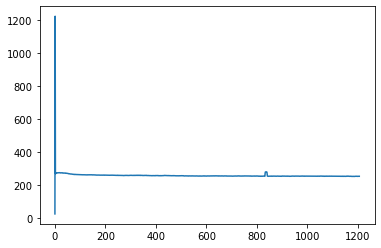

In [103]:
print(f'inicio {inicio} fin {fin}')
plt.plot(datos3)

## Cargando datos

### Cargar todas las columnas (predeterminado)

In [ ]:
df = next(fridge.load())
df.head()

### Carga una sola columna de datos de energía

Utilice `fridge.power_series ()` que devuelve un generador de objetos `pandas.Series` unidimensionales, cada uno de los cuales contiene datos de energía utilizando el tipo de CA más 'sensible':

In [ ]:
series = next(fridge.power_series())
series.head()

o, para obtener potencia activa:

In [ ]:
series = next(fridge.power_series(ac_type='active'))
series.head()

# MeterGroup, ElecMeter, selección y estadísticas básicas

Todos los conjuntos de datos de NILM consisten en varios grupos de medidores de electricidad. Podemos agrupar los contadores por casa. O por el tipo de aparato al que están conectados directamente. O por frecuencia de muestreo. O si el medidor es un "medidor de sitio" para toda la casa o un submedidor a nivel de electrodomésticos, o un submedidor a nivel de circuito.

En NILMTK, una de las clases clave es `MeterGroup` que almacena una lista de` medidores` y nos permite seleccionar un subconjunto de medidores, la potencia agregada de todos los medidores y muchas otras funciones.

Cuando abrimos por primera vez un `DataSet`, NILMTK crea varios objetos` MeterGroup`. Hay `nilmtk.global_meter_group` que contiene todos los medidores cargados actualmente (incluso de varios conjuntos de datos si ha abierto más de un conjunto de datos). También hay un `MeterGroup` por edificio (que vive en el atributo` Building.elec`). También anidamos "MeterGroups" para agregar redes de fase dividida, red trifásica y aparatos de suministro dual (240 voltios) en conjuntos de datos de América del Norte y Canadá. Por ejemplo, aquí está el `MeterGroup` para el edificio 1 en REDD:

**NOTA**: Si está en Windows, recuerde evitar las barras invertidas, use barras inclinadas hacia adelante o use cadenas sin procesar cuando pase rutas en Python, p. Ej. uno de los siguientes funcionaría:

```python
redd = DataSet('c:\\data\\redd.h5')
redd = DataSet('c:/data/redd.h5')
redd = DataSet(r'c:\data\redd.h5')
```

In [ ]:
%matplotlib inline

In [ ]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import nilmtk
from nilmtk import DataSet, MeterGroup

plt.style.use('ggplot')
rcParams['figure.figsize'] = (13, 10)

#redd = DataSet('/data/redd.h5')
elec = redd.buildings[1].elec
elec

Tenga en cuenta que hay dos `MeterGroups` anidados: uno para el horno eléctrico y otro para la lavadora secadora (ambos son electrodomésticos de 240 voltios y tienen dos medidores por electrodoméstico):

In [ ]:
elec.nested_metergroups()

Poner estos medidores en un "MeterGroup" nos permite sumar fácilmente la demanda de energía registrada por ambos medidores para obtener la demanda de energía total para todo el aparato (pero también es muy fácil ver la demanda de energía del medidor individual).

Podemos obtener fácilmente un grupo de medidores de los submedidores o de la red:

In [ ]:
elec.mains()

Podemos obtener fácilmente la suma de los datos de potencia de ambos medidores de red:

In [ ]:
elec.mains().power_series_all_data().head()

In [ ]:
elec.submeters()

## Estadísticas para grupos de medidores

### Proporción de energía submedida

Calculemos la proporción de energía submedida en el edificio 1 de REDD:

In [ ]:
elec.proportion_of_energy_submetered()

Tenga en cuenta que NILMTK ha emitido una advertencia de que Mains usa un tipo diferente de medición de potencia que todos los submedidores, por lo que no es una comparación del todo precisa. Lo que plantea la pregunta: ¿qué tipo de medidas de potencia se utilizan para la red y los submedidores? Vamos a averiguar...

### Potencia activa, aparente y reactiva

In [ ]:
mains = elec.mains()

In [ ]:
mains.available_ac_types('power')

In [ ]:
elec.submeters().available_ac_types('power')

In [ ]:
next(elec.load())

### Energía total

In [ ]:
elec.mains().total_energy() # retorna kWh

### Energy per submeter

In [ ]:
energy_per_meter = elec.submeters().energy_per_meter() # kWh, again
energy_per_meter

los encabezados de columna son los números de instancia de ElecMeter.

La función `fracción_por_metro` hace lo mismo que ʻenergía por submímetro` pero devuelve la fracción de energía por metro.

### Seleccionar contadores en función de su consumo de energía

Hagamos un nuevo MeterGroup que solo contenga los ElecMeters que usaron más de 20 kWh:

In [ ]:
# energy_per_meter es un DataFrame donde cada fila 
#es un tipo de potencia ('activa', 'reactiva' o 'aparente'). 
#Todos los medidores de electrodomésticos en REDD están registrados 
#como 'activos', así que simplemente seleccione la fila 'activo':
energy_per_meter = energy_per_meter.loc['active']
more_than_20 = energy_per_meter[energy_per_meter > 20]
more_than_20

In [ ]:
instances = more_than_20.index
instances

## Grafica la fracción del consumo de energía de cada aparato

In [ ]:
fraction = elec.submeters().fraction_per_meter().dropna()

In [ ]:
# Crea etiquetas convenientes
labels = elec.get_labels(fraction.index)
plt.figure(figsize=(10,30))
fraction.plot(kind='pie', labels=labels);

### Dibujar diagrama de cableado
Podemos obtener el diagrama de cableado para MeterGroup:

In [ ]:
elec.draw_wiring_graph()

No es muy bonito, pero muestra que los medidores (1,2) (los medidores del sitio) están aguas arriba de todos los demás medidores.

Los edificios en REDD tienen solo dos niveles en su jerarquía de medidores (red y submedidores). Si hubiera más de dos niveles, podría ser útil obtener solo los medidores inmediatamente aguas abajo de la red:

In [ ]:
elec.meters_directly_downstream_of_mains()

### Traza los aparatos cuando están en uso

In [ ]:
# sns.set_palette ("Set3", n_colors = 12)
# Establezca un umbral para eliminar el ruido de energía residual cuando los dispositivos están apagados
elec.plot_when_on(on_power_threshold = 40)

## Estadísticas e información para medidores individuales

La clase ʻElecMeter` representa un solo medidor de electricidad. Cada ʻElecMeter` tiene una lista de objetos ʻAppliance` asociados. ʻElecMeter` tiene muchos de los mismos métodos de estadísticas que `MeterGroup`, como` total_energy` y ʻavailable_power_ac_types` y `power_series` y` power_series_all_data`. Ahora exploraremos algunas funciones de estadísticas más (muchas de las cuales también están disponibles en `MeterGroup`) ...

In [ ]:
#Verifiquemos el refrigerador
fridge_meter = elec['fridge']

### Obtener medidor de aguas arriba

In [ ]:
fridge_meter.upstream_meter() # resulta ser el grupo de medidores de red!

### Metadatos sobre la clase de medidor

In [ ]:
fridge_meter.device

### Aparato dominante

Si los metadatos especifican que un medidor tiene varios medidores conectados, entonces uno de ellos puede especificarse como el dispositivo 'dominante', y este dispositivo puede recuperarse con este método:

In [ ]:
fridge_meter.dominant_appliance()

### Energía total

In [ ]:
fridge_meter.total_energy() # kWh

### Obtén buenas secciones

Si trazamos los datos de potencia sin procesar, vemos que hay una gran brecha donde, supuestamente, el sistema de medición no estaba funcionando. (si tuviéramos que acercarnos, también veríamos muchos espacios más pequeños):

In [ ]:
fridge_meter.plot()

Podemos identificar automáticamente las 'secciones buenas' (es decir, las secciones en las que cada par de muestras consecutivas es menor que 'max_sample_period` especificado en los metadatos del conjunto de datos):

In [ ]:
good_sections = fridge_meter.good_sections(full_results=True)
# especificar full_results = False nos daría una lista simple de TimeFrames. 
#Pero queremos el objeto GoodSectionsResults completo para poder trazar las secciones buenas ...

In [ ]:
good_sections.timeframes()

In [ ]:
good_sections.plot()

Los trozos azules muestran dónde son buenos los datos. La brecha blanca es la gran brecha que se observa en los datos de potencia bruta. Hay muchos huecos más pequeños que no podemos ver en este nivel de zoom.

También podemos ver las secciones exactas identificadas:

In [ ]:
good_sections.combined()

In [ ]:
#Para un medidor central 1
#Verifiquemos el refrigerador
siteMeter = elec.mains()[1]
siteMeter.plot()

In [ ]:
#Seleccionar secciones de buen funcionamiento
good_sections_main1 = siteMeter.good_sections(full_results=True)
#Graficar 
good_sections_main1.plot()

In [ ]:
#Ver todos los intervalos de buen funcionamiento
good_sections_main1.combined()

### Taza de abando o faltante

Además de la aparición de grandes lagunas debido a que todo el sistema está inactivo, también obtenemos pequeñas lagunas frecuentes de los sensores inalámbricos que arrojan datos. A esto a veces se le llama "abandono". La tasa de abandono es un número entre 0 y 1 que especifica la proporción de muestras faltantes. Una tasa de abandono de 0 significa que no faltan muestras. Un valor de 1 significaría que faltan todas las muestras:

In [ ]:
fridge_meter.dropout_rate()

Tenga en cuenta que la tasa de deserción ha disminuido (¡lo cual es bueno!) Ahora que estamos ignorando las brechas. Este valor probablemente sea más representativo del rendimiento del sistema inalámbrico.

## Seleccionar subgrupos de medidores

Usamos ʻElecMeter.select_using_appliances () `para seleccionar un nuevo MeterGroup usando un campo de metadatos. Por ejemplo, para obtener todas las lavadoras secadoras del conjunto de datos REDD:

In [ ]:
import nilmtk
nilmtk.global_meter_group.select_using_appliances(type='washer dryer')

O seleccione varios tipos de dispositivos:

In [ ]:
elec.select_using_appliances(type=['fridge', 'microwave'])

O todos los electrodomésticos de la categoría 'calefacción':

In [ ]:
nilmtk.global_meter_group.select_using_appliances(category='heating')

O todos los electrodomésticos del edificio 1 con motor de inducción monofásico (!):

In [ ]:
nilmtk.global_meter_group.select_using_appliances(building=1, category='single-phase induction motor')

(NILMTK importa los 'metadatos comunes' del proyecto de metadatos NILM, que incluye una amplia gama de diferentes [taxonomías de categoría] (http://nilm-metadata.readthedocs.org/en/latest/central_metadata.html#appliancetype))

In [ ]:
nilmtk.global_meter_group.select_using_appliances(building=2, category='laundry appliances')

### Seleccione un grupo de medidores de las propiedades de los medidores (no de los electrodomésticos)

In [ ]:
elec.select(device_model='REDD_whole_house')

In [ ]:
elec.select(sample_period=3)

## Seleccione un solo medidor de un grupo de medidores

Usamos "[]" para recuperar un solo "Medidor eléctrico" de un "Grupo de medidores".

### Busque un medidor usando aparatos conectados a cada medidor

In [ ]:
elec['fridge']

Los electrodomésticos se identifican de forma única dentro de un edificio por un "tipo" (nevera, hervidor, televisión, etc.) y un número de "instancia". Si no especificamos un número de instancia, entonces ʻlecMeter` recupera la instancia 1 (la numeración de instancias comienza desde 1). Si desea una instancia diferente, simplemente haga esto:

**Nota:** Instancia hace referencia a la casa donde se tomo la medida

In [ ]:
elec.select_using_appliances(type='fridge')

In [ ]:
elec['light', 2]

Para identificar de forma única un dispositivo en `nilmtk.global_meter_group`, debemos especificar el nombre del conjunto de datos, el número de instancia del edificio, el tipo de dispositivo y la instancia del dispositivo en un dict:

In [ ]:
import nilmtk
nilmtk.global_meter_group[{'dataset': 'REDD', 'building': 1, 'type': 'fridge', 'instance': 1}]

### Busque un medidor usando los detalles del ElecMeter
obtener ElecMeter con instancia = 1:

In [ ]:
elec[1]

### Numeración de instancias
Los números de instancia de ElecMeter y Appliance identifican de manera única el tipo de medidor o dispositivo dentro del *edificio*, no globalmente. Para identificar de forma única un medidor a nivel global, necesitamos tres claves:

In [ ]:
from nilmtk.elecmeter import ElecMeterID 
# ElecMeterID es una tupla con nombre para identificar de forma única cada ElecMeter

nilmtk.global_meter_group[ElecMeterID(instance=8, building=1, dataset='REDD')]

### Seleccione MeterGroup anidado
También podemos seleccionar un solo MeterGroup anidado existente. Hay dos formas de especificar un MeterGroup anidado:

In [ ]:
elec[[ElecMeterID(instance=3, building=1, dataset='REDD'), 
      ElecMeterID(instance=4, building=1, dataset='REDD')]]

In [ ]:
elec[ElecMeterID(instance=(3,4), building=1, dataset='REDD')]

También podemos especificar la red solicitando la instancia de medidor 0:

In [ ]:
elec[ElecMeterID(instance=0, building=1, dataset='REDD')]

que es equivalente a elec.mains ():

In [ ]:
elec.mains() == elec[ElecMeterID(instance=0, building=1, dataset='REDD')]

## Grafica datos submedidos para un solo día

In [ ]:
redd.set_window(start='2011-04-21', end='2011-04-22')
elec.plot();
plt.xlabel("Time");

## Gráfico de autocorrelación

In [ ]:
from pandas.plotting import autocorrelation_plot

In [ ]:
elec.mains().plot_autocorrelation();

## Consumo diario de energía en todos los frigoríficos del conjunto de datos

In [ ]:
fridges_restricted = nilmtk.global_meter_group.select_using_appliances(type='fridge')
daily_energy = pd.Series([meter.average_energy_per_period(offset_alias='D') 
                          for meter in fridges_restricted.meters])

# daily_energy.plot(kind='hist');
# plt.title('Histogram of daily fridge energy');
# plt.xlabel('energy (kWh)');
# plt.ylabel('occurences');
# plt.legend().set_visible(False)

daily_energy

## Dataframe de correlación de los dispositivos

In [ ]:
correlation_df = elec.pairwise_correlation()
correlation_df

# API de experimentación rápida NILMTK

### Este cuaderno demuestra el uso de ExperimentAPI de NILMTK, una nueva interfaz NILMTK que permite a los usuarios de NILMTK centrarse en qué experimentos ejecutar en lugar del código necesario para ejecutar dichos experimentos.

Es importante tener en cuenta que entregar tanta flexibilidad al usuario requiere que el usuario esté algo familiarizado con el conjunto de datos, pero esta parte del proceso es compatible con NILMTK ya que la exploración de datos es simple y está bien documentada.

Comencemos con un experimento muy simple para demostrar el uso de la API para múltiples dispositivos en un caso de uso mínimo. Este experimento muestra cómo el usuario puede seleccionar los dispositivos en el conjunto de datos en los que se realizará la desagregación.

Importando la API:

In [ ]:
from nilmtk.api import API
import warnings
warnings.filterwarnings("ignore")

A continuación, importamos los algoritmos necesarios en los que deseamos ejecutar los experimentos.

In [ ]:
from nilmtk.disaggregate import CO

A continuación, ingresamos los valores para los diferentes parámetros en el diccionario. Dado que necesitamos varios dispositivos, ingresamos los nombres de todos los dispositivos necesarios en el parámetro _'appliances'_.

In [ ]:
experiment1 = {
  'power': {'mains': ['apparent','active'],'appliance': ['apparent','active']},
  'sample_rate': 60,
  'appliances': ['washing machine','fridge'],
  'methods': {"CO":CO({})},
  'train': {    
    'datasets': {
        'REDD': {
            #'path': 'data/dataport.hdf5',
            'path':  'C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5',
            'buildings': {
                #10: {
                1: {
                    #'start_time': '2015-04-04',
                    #'end_time': '2015-04-06'
                    'start_time': '2011-04-17',
                    'end_time': '2011-04-27'
                    }
                }                
            }
        }
    },
  'test': {
    'datasets': {
        'REDD': {
            #'path': 'data/dataport.hdf5',
            'path':  'C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5',
            'buildings': {
                1: {
                #10: {
                    #'start_time': '2015-04-25',
                    #'end_time': '2015-04-26'
                    'start_time': '2011-04-18',
                    'end_time' : '2011-04-19'
                    }
                }
            }
        },
        'metrics':['rmse']
    }
}

En esta configuración experimental de ejemplo, hemos establecido el _sample rate_ en 60Hz. Usamos la optimización combinatoria para desagregar los dispositivos requeridos del edificio 1, en el conjunto de datos del REDD. Con la métrica _RMSE_ para medir la precisión. También especificamos las fechas para la formación y las pruebas.

A continuación, proporcionamos este diccionario de experimentos como entrada a la API.

In [ ]:
api_results_experiment_1 = API(experiment1)

Podemos observar las gráficas de predicción versus verdad en la celda anterior. Se puede acceder a las métricas de precisión mediante los siguientes comandos:

In [ ]:
errors_keys = api_results_experiment_1.errors_keys
errors = api_results_experiment_1.errors
for i in range(len(errors)):
    print (errors_keys[i])
    print (errors[i])
    print ("\n\n")

Este fue un experimento trivial que solo rasca la superficie del verdadero potencial de esta API.

En el próximo experimento, ejecutaremos una versión cada vez más compleja del experimento anterior. Aquí usaremos varios modelos para desagregar las lecturas del dispositivo con los modelos que tienen sus propios conjuntos de parámetros que los usuarios pueden establecer dentro del diccionario experimental para ajustar los experimentos.

También importamos los algoritmos necesarios para los próximos experimentos.

In [ ]:
from nilmtk.disaggregate import fhmm_exact, Mean

In [ ]:
experiment2 = {
  'power': {'mains': ['apparent','active'],'appliance': ['apparent','active']},
  'sample_rate': 60,
  #'appliances': ['fridge','dish washer', 'microwave'], 
  'appliances': ['fridge','dish washer', 'unknown'],
  #'methods': {"Mean":Mean({}),"FHMM_EXACT":fhmm_exact({'num_of_states':2}), "CombinatorialOptimisation":CO({})},
    'methods': {"Mean":Mean({}), "CombinatorialOptimisation":CO({})},
  'train': {    
    'datasets': {
        'REDD': {
            'path':  'C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5',
            'buildings': {
                1: {
                    'start_time': '2011-04-17',
                    'end_time': '2011-04-27'
                    }
                }                
            }
        }
    },
  'test': {
    'datasets': {
        'REDD': {
            'path':  'C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5',
            'buildings': {
                1: {
                    'start_time': '2011-04-18',
                    'end_time' : '2011-04-19'
                    }
                }
            }
        },
        'metrics':['mae', 'rmse']
    }
}

In [ ]:
api_results_experiment_2 = API(experiment2)

In [ ]:
api_results_experiment_2.errors

In [ ]:
errors_keys = api_results_experiment_2.errors_keys
errors = api_results_experiment_2.errors
for i in range(len(errors)):
    print (errors_keys[i])
    print (errors[i])
    print ("\n\n")

La API hace que la ejecución de experimentos sea extremadamente rápida y eficiente, con el énfasis en la creación de experimentos reproducibles finamente ajustados donde el rendimiento del modelo y los parámetros se puede evaluar fácilmente de un vistazo.

En la siguiente iteración de este experimento, introducimos más parámetros _chunksize_, _DROP_ALL_NANS_ y _artificial_aggregate_ y agregamos otro algoritmo de desagregación (_Hart85_). También entrenamos y probamos datos de varios edificios del mismo conjunto de datos.

También importamos el algoritmo de Hart para el próximo experimento

In [ ]:
from nilmtk.disaggregate import Hart85


... Se suspende esta parte no me aporta nada a mi trabajo 

Al igual que los experimentos anteriores, cualquier usuario puede configurar otros experimentos muy rápidamente.

# Desagregación

In [ ]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline

In [ ]:
rcParams['figure.figsize'] = (13, 6)

### División de datos en tren y conjunto de prueba

In [ ]:
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')

Usemos el edificio 1 con fines de demostración

In [ ]:
building = 1

Dividamos los datos el 30 de abril

In [ ]:
train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

### Visualizando los datos

In [ ]:
train_elec.plot()

In [ ]:
test_elec.mains().plot()

El conjunto de datos REDD tiene datos de nivel de electrodomésticos muestreados cada 3 o 4 segundos y datos de red tomados cada segundo. Comprobemos lo mismo.

In [ ]:
fridge_meter = train_elec['fridge']

In [ ]:
fridge_df = next(fridge_meter.load())

In [ ]:
fridge_df.head()

In [ ]:
mains = train_elec.mains()

In [ ]:
mains_df = next(mains.load())

In [ ]:
mains_df.head()

Dado que ambos se muestrean a diferentes frecuencias, reduciremos la resolución de ambos a una resolución de 1 minuto. También seleccionaremos los 5 mejores electrodomésticos en términos de consumo de energía y los usaremos para entrenar nuestros modelos FHMM y CO.

### Selección de los 5 mejores electrodomésticos

In [ ]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

In [ ]:
top_5_train_elec

### Capacitación y desagregación

#### Una función para desagregar los datos de la red a los electrodomésticos constituyentes y devolver las predicciones

In [ ]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    # "ac_type" varía según el conjunto de datos utilizado.
    # Asegúrese de usar el ac_type correcto antes de usar los parámetros predeterminados en este código.
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

#### Entrena usando 2 algoritmos de evaluación comparativa: Optimización combinatoria (CO) y Modelo de Markov oculto factorial (FHMM)

In [ ]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

¡Usando etiquetas más bonitas!

In [ ]:
appliance_labels = [m.label() for m in gt.columns.values]

In [ ]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

#### Echa un vistazo a la verdad básica del consumo de energía de los 5 principales dispositivos

In [ ]:
gt.head()

In [ ]:
predictions['CO'].head()

In [ ]:
predictions['FHMM'].head()

### Trazar las predicciones contra el uso real

In [ ]:
predictions['CO']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

In [ ]:
predictions['FHMM']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

### Comparación de algoritmos NILM (CO vs FHMM)

`nilmtk.utils.compute_rmse` es una extensión de lo siguiente, que maneja mejor tanto los valores perdidos como las etiquetas: 

```python
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)
```

In [ ]:
#? nilmtk.utils.compute_rmse

In [ ]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse

# Diasagregue los datos del medidor de red de su hogar / edificio

Este cuaderno demuestra el uso de siteonlyapi, una nueva interfaz NILMTK que es una modificación de ExperimentAPI de NILMTK. Permite a los usuarios de NILMTK obtener las demandas de energía de sus hogares / edificios para diferentes electrodomésticos potenciales.

Comencemos con un experimento muy simple para demostrar el uso de esta API. Este experimento muestra cómo el usuario puede convertir los datos de su medidor en el formato REDD adecuado y llamar a la API para desagregar la energía en las demandas de los electrodomésticos según el conjunto de capacitación.

Convierta los datos del medidor al formato adecuado